In [ ]:
# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew
import scipy as sp
from scipy.stats import chi2_contingency

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression # Régression logistique
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.ensemble import BaggingClassifier # Bagging


# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
 ## YellowBrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [ ]:
data = pd.read_csv('../data/smoking_driking_dataset_Ver01.csv', nrows=100000)
df_smoking_drinking = data.copy()

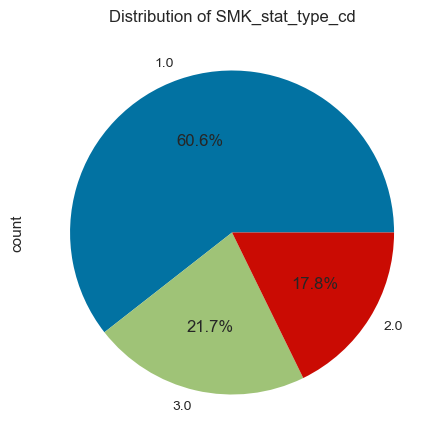

In [ ]:
# Affichage des valeurs uniques de la variable SMK_stat_type_cd sous forme de camembert
plt.figure(figsize=(10, 5))
df_smoking_drinking['SMK_stat_type_cd'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of SMK_stat_type_cd')
plt.show()

La répartition des labels est bien similaire au jeu de données réel

In [ ]:
from preprocessing import split_data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_smoking_drinking, 'SMK_stat_type_cd')

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (69999, 23)
X_val shape: (10000, 23)
X_test shape: (20001, 23)


# Séparation variables continue/catégorielles

In [ ]:
# Normalisation des variables continues
from sklearn.preprocessing import StandardScaler

cont_features = df_smoking_drinking.select_dtypes('float64').columns
cont_features = cont_features.drop('SMK_stat_type_cd')

cat_features = df_smoking_drinking.select_dtypes(include = ['int64', 'object']).columns
cat_features = cat_features.drop(['DRK_YN'])

## SVM - Pipeline

In [ ]:
def create_svc_pipeline(cat_features, cont_features, kernel='linear', C=1.0, gamma='scale', degree=3, coef0=0.0):
    # Créer les pipelines pour les caractéristiques catégorielles et numériques
    categoricalPipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  # Gérer les catégories inconnues
    )

    numericPipeline = make_pipeline(
        SimpleImputer(),
        StandardScaler()
    )

    # Créer le préprocesseur
    preprocessor_robust = make_column_transformer(
        (categoricalPipeline, cat_features),
        (numericPipeline, cont_features)
    )

    # Créer le pipeline SVM avec les paramètres spécifiés
    svr_pipe = make_pipeline(preprocessor_robust, 
                             SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0))
    return svr_pipe

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

svc_pipe_linear = create_svc_pipeline(cat_features, cont_features, kernel='linear')
svc_pipe_rbf = create_svc_pipeline(cat_features, cont_features, kernel='rbf', C=1.0, gamma='scale')
svc_pipe_poly = create_svc_pipeline(cat_features, cont_features, kernel='poly', coef0=1)


### SVM - Entraînement

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print('\n\n')
    print(f"--- Evaluation du modèle : {model_name} ---")

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_test_pred = model.predict(X_test)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Accuracy:', accuracy)
    print('F1:', f1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.title(f"Confusion Matrix for {model_name}")  # Add model name to the title
    disp.plot()


    # Rapport de classification
    print(classification_report(y_test, y_test_pred))

    # Score du modèle
    score = model.score(X_test, y_test)
    print('Score :', score)
    
    return accuracy, f1, score




--- Evaluation du modèle : SVC linear kernel ---
Accuracy: 0.680165991700415
F1: 0.6936209396628715
              precision    recall  f1-score   support

         1.0       0.90      0.75      0.82     12112
         2.0       0.44      0.43      0.43      3551
         3.0       0.47      0.70      0.56      4338

    accuracy                           0.68     20001
   macro avg       0.60      0.63      0.60     20001
weighted avg       0.73      0.68      0.69     20001

Score : 0.680165991700415



--- Evaluation du modèle : SVC RBF kernel ---
Accuracy: 0.6938653067346633
F1: 0.7004263168149192
              precision    recall  f1-score   support

         1.0       0.87      0.79      0.83     12112
         2.0       0.45      0.41      0.43      3551
         3.0       0.49      0.65      0.56      4338

    accuracy                           0.69     20001
   macro avg       0.60      0.62      0.61     20001
weighted avg       0.71      0.69      0.70     20001

Score : 

(0.6943652817359132, 0.7020458932053381, 0.6943652817359132)

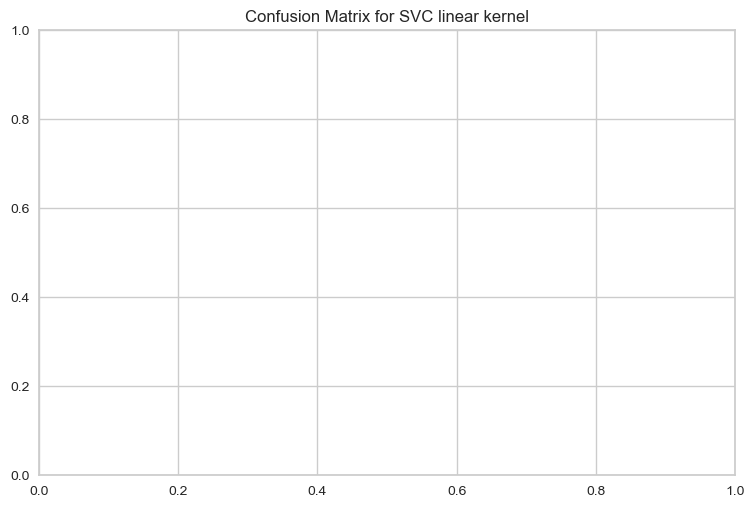

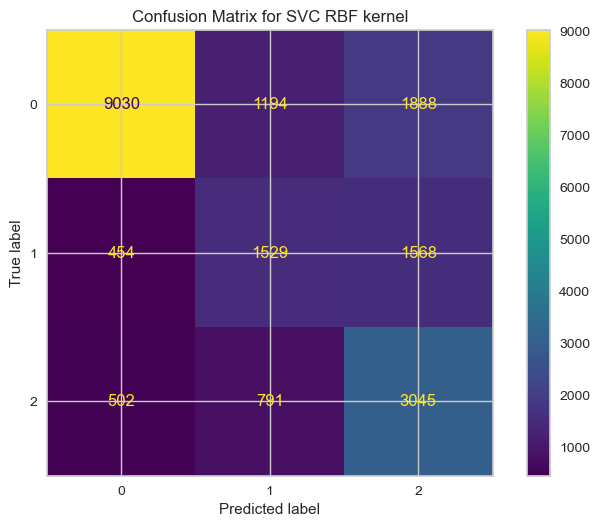

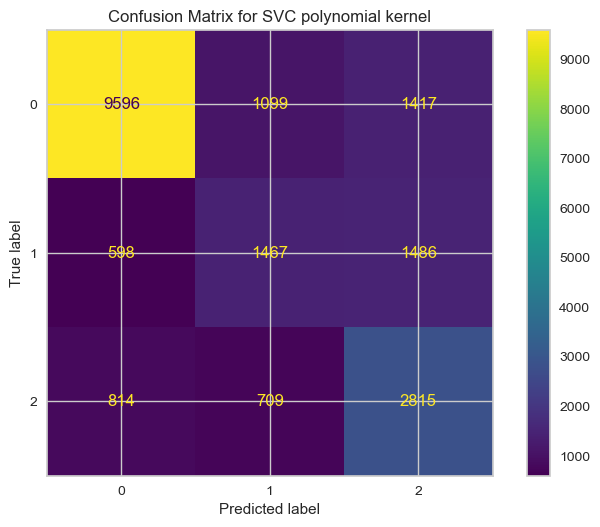

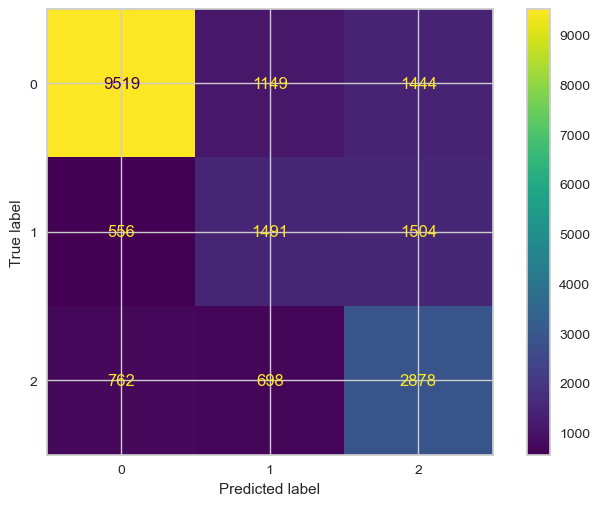

In [ ]:
train_and_evaluate_model(svc_pipe_linear, X_train, y_train, X_test, y_test, model_name='SVC linear kernel')
train_and_evaluate_model(svc_pipe_rbf, X_train, y_train, X_test, y_test, model_name='SVC RBF kernel')
train_and_evaluate_model(svc_pipe_poly, X_train, y_train, X_test, y_test, model_name='SVC polynomial kernel')


Sans optimisation, le <b><font color='red'>score du SVC linéaire est à 68.2% </font></b>

In [ ]:
def plot_learning_curve(pipeline, X_train, y_train, model_name="SVC", cv=3, scoring='accuracy'):
    # Extract the SVC estimator from the pipeline
    svc = pipeline.named_steps['svc']
    
    plt.figure()
    visualizer = LearningCurve(
        svc,  # Use the SVC estimator directly
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    visualizer.fit(pipeline[:-1].transform(X_train), y_train)  # Apply the pipeline except the last step
    visualizer.finalize()  # Finalize the visualizer to ensure it draws correctly
    visualizer.show(title=f"Learning Curve for {model_name}")  # Set the title directly

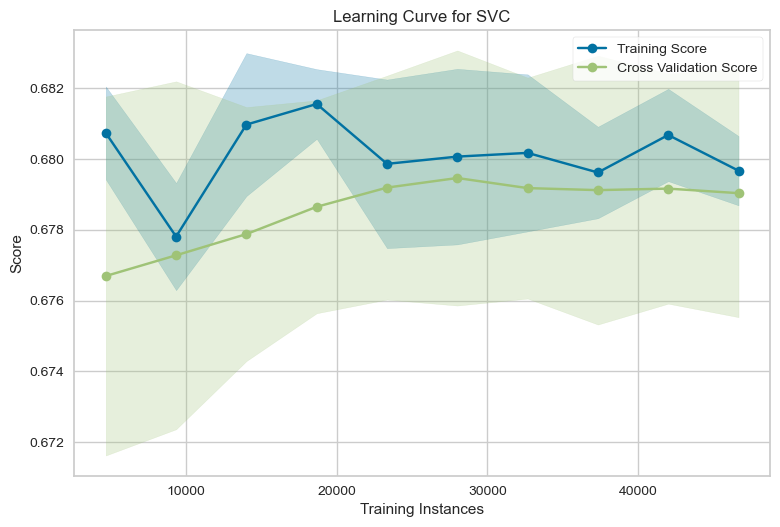

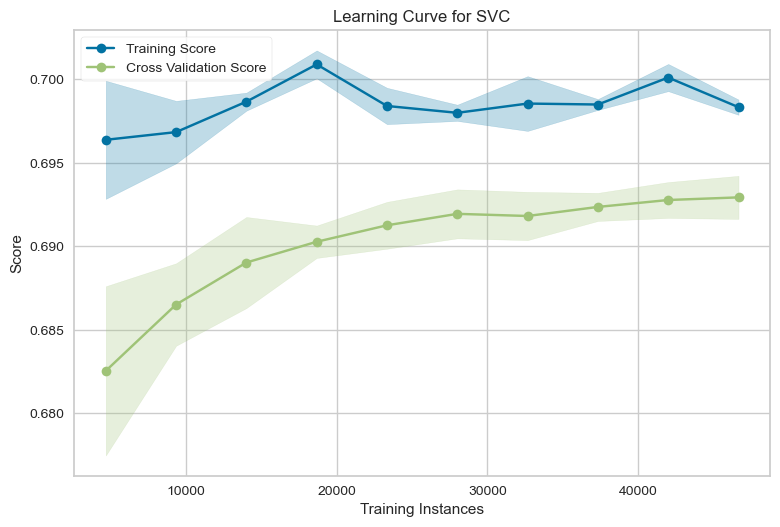

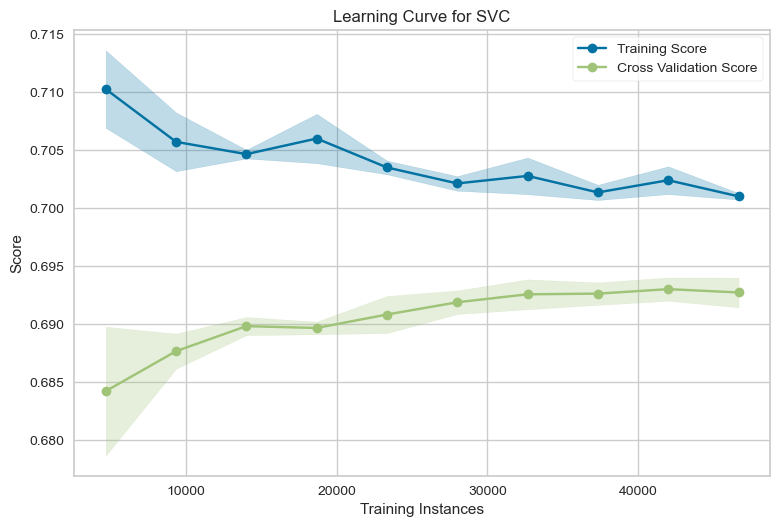

In [ ]:
# 1h40
plot_learning_curve(svc_pipe_linear, X_train, y_train, model_name="SVC avec noyau linéaire")
plot_learning_curve(svc_pipe_rbf, X_train, y_train, model_name="SVC avec noyau RBF")
plot_learning_curve(svc_pipe_poly, X_train, y_train, model_name="SVC avec noyau polynomial")

In [ ]:
def plot_validation_curve(pipeline, X_train, y_train, param_name, param_range, model_name="SVC", cv=3, scoring='accuracy'):
    # Extract the SVC estimator from the pipeline
    svc = pipeline.named_steps['svc']
    
    plt.figure()
    visualizer = ValidationCurve(
        svc, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    visualizer.fit(pipeline[:-1].transform(X_train), y_train)  # Apply the pipeline except the last step
    visualizer.finalize()  # Finalize the visualizer to ensure it draws correctly
    plt.show()  # Ensure the plot is displayed

KeyboardInterrupt: 

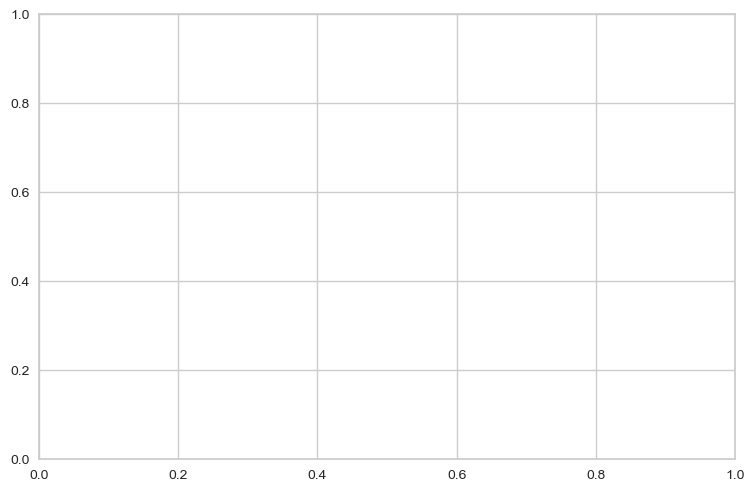

In [ ]:
# Affichage de la courbe de validation pour le paramètre 'C'
param_range_C = np.logspace(-3, 2, 6)  # Valeurs pour C
plot_validation_curve(svc_pipe_linear, X_train, y_train, param_name='C', param_range=param_range_C, model_name="SVC avec noyau linéaire")

# Affichage de la courbe de validation pour le paramètre 'gamma'
param_range_gamma = np.logspace(-4, 1, 6)  # Valeurs pour gamma
plot_validation_curve(svc_pipe_rbf, X_train, y_train, param_name='gamma', param_range=param_range_gamma, model_name="SVC avec noyau RBF")

# Affichage de la courbe de validation pour le paramètre 'degree'
param_range_degree = [2, 3, 4, 5, 6]  # Valeurs pour degree
plot_validation_curve(svc_pipe_poly, X_train, y_train, param_name='degree', param_range=param_range_degree, model_name="SVC avec noyau polynomial")

In [ ]:
import optuna

def hyperoptimize_svc_model(pipeline, X_train, y_train, X_test, y_test, kernel='linear', n_trials=5, timeout=600):
    # Définissez la fonction objective pour Optuna
    def objective(trial):
        if kernel == 'linear':
            C = trial.suggest_loguniform('svc__C', 1e-3, 1e1)
            pipeline.set_params(svc__C=C)
        elif kernel == 'rbf':
            C = trial.suggest_loguniform('svc__C', 1e-3, 1e1)
            gamma = trial.suggest_loguniform('svc__gamma', 1e-4, 1e1)
            pipeline.set_params(svc__C=C, svc__gamma=gamma)
        elif kernel == 'poly':
            C = trial.suggest_loguniform('svc__C', 1e-3, 1e1)
            degree = trial.suggest_int('svc__degree', 2, 5)
            pipeline.set_params(svc__C=C, svc__degree=degree)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        # Apply the preprocessing steps except the last step
        X_train_transformed = pipeline[:-1].fit_transform(X_train, y_train)
        score = cross_val_score(pipeline.named_steps['svc'], X_train_transformed, y_train, cv=3, scoring='accuracy').mean()
        return score

    # Créez un objet study et optimisez la fonction objective
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Affichez les meilleurs hyperparamètres
    print('Best parameters:', study.best_params)

    # Entraînez le modèle avec les meilleurs hyperparamètres
    pipeline.set_params(**study.best_params)
    pipeline.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_test_pred = pipeline.predict(X_test)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Accuracy on test set:', accuracy)
    print('F1 score on test set:', f1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for SVC with {kernel} kernel")
    plt.show()

    # Rapport de classification
    print(classification_report(y_test, y_test_pred))

    return study.best_params, accuracy, f1


In [ ]:
# Hyper-optimisation pour un noyau linéaire
best_params_linear, accuracy_linear, f1_linear = hyperoptimize_svc_model(
    svc_pipe_linear, X_train, y_train, X_test, y_test, kernel='linear', n_trials=5, timeout=600)

# Hyper-optimisation pour un noyau RBF
best_params_rbf, accuracy_rbf, f1_rbf = hyperoptimize_svc_model(
    svc_pipe_rbf, X_train, y_train, X_test, y_test, kernel='rbf', n_trials=5, timeout=600)

# Hyper-optimisation pour un noyau polynomial
best_params_rbf, accuracy_rbf, f1_rbf =poly, f1_poly = hyperoptimize_svc_model(
    svc_pipe_poly, X_train, y_train, X_test, y_test, kernel='poly', n_trials=5, timeout=600)

[I 2024-06-12 00:21:10,161] A new study created in memory with name: no-name-bb47be44-6c2b-43e3-b14f-436fefb5b796


Après optimisation, le gain est faible avec un <b><font color='red'>F1 score à 69.7% </font></b> pour le noyau linéaire